In [14]:
import logging
import h5py
from numpy import zeros
from numpy import ones
from numpy.lib.financial import nper
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.signal import spectrogram, istft, stft
import numpy as np

In [2]:
def plot_single_stream(do, label, fs, nperseg):
    d0 = pd.DataFrame(data=do)

    fig = plt.figure(figsize=(16, 16), dpi=80)
    ax1 = plt.subplot2grid((4, 1), (0, 0))
    ax2 = plt.subplot2grid((4, 1), (1, 0))
    ax3 = plt.subplot2grid((4, 1), (2, 0), rowspan=2)

    plt.subplots_adjust(hspace=0.5)

    sns.lineplot(data=do, ax=ax1, linewidth=1, legend=None)

    ax1.set_title("Waveform")
    ax1.set(xlabel="Samples", ylabel="Amplitude counts")
    ax1.locator_params(nbins=6, axis="y")

    f, t, Sxx = spectrogram(x=do, fs=fs)

    ax2.clear()
    ax2.set_title("Spectrogram")
    _ax2 = ax2.pcolormesh(t, f, Sxx, shading="gouraud")
    ax2.set(xlabel="Time [sec]", ylabel="Frequency [Hz]")
    fig.colorbar(_ax2, ax=ax2)

    f_sftt, t_sftt, Zxx = stft(do, window="hanning", fs=fs, nperseg=nperseg)

    ax3.clear()
    ax3.set_title("STFT")
    _ax3 = ax3.pcolormesh(t_sftt, f_sftt, np.abs(Zxx), shading="auto")
    fig.colorbar(_ax3, ax=ax3)

    plt.suptitle(label, fontsize=14)

In [18]:
def make_generator_model(latent_dim):
    model = Sequential()
    model.add(layers.Dense(1 * 1 * 128, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((1, 1, 128)))

    model.add(
        layers.Conv2DTranspose(
            64, (60, 60), strides=(64, 64), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.1))

    model.add(
        layers.Conv2DTranspose(
            64, (2, 2), strides=(1, 1), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.1))

    model.add(
        layers.Conv2DTranspose(
            64, (2, 2), strides=(1, 1), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.1))

    model.add(
        layers.Conv2DTranspose(
            64, (2, 2), strides=(1, 1), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.1))

    model.add(
        layers.Conv2DTranspose(
            64, (2, 2), strides=(1, 1), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.1))

    model.add(
        layers.Conv2DTranspose(
            1,
            (1, 1),
            strides=(1, 1),
            padding="same",
            use_bias=False,
            activation="linear",
        )
    )

    return model

In [4]:
def make_discriminator_model():
    model = Sequential()

    model.add(layers.Conv2D(128, (1, 1), padding="same", input_shape=[64, 64, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, (2, 2), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, (2, 2), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(128, (2, 2), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(128, (2, 2), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(128, (2, 2), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))

    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [5]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt)
    return model

In [6]:
def load_real_samples(arr_len=10000):
    with h5py.File("data/STEAD-processed-stft-64.hdf5", "r") as f:
        # keys = f["keys"][:arr_len]
        # components = f["components"][:arr_len]
        data = f["data"][:arr_len]
        data = data.reshape(data.shape[0], 64, 64, 1)
        return data

In [7]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

In [35]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = 100 * randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [9]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

In [10]:
# create and save a plot of generated images
def save_plot(examples, epoch):
    examples = examples.reshape(examples.shape[0], 64, 64)
    for idx, _ in enumerate(examples[:5]):
        inversed = istft(examples[idx], window="hanning", fs=66, nperseg=127)
        plot_single_stream(
            inversed[1][:4000],
            f"GAN Event (epoch {epoch+1})",
            fs=66,
            nperseg=127,
            file_path=f"out/epoch_{epoch+1}_image_{idx}.png"
        )

In [11]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    logging.info(f">Accuracy real: {acc_real * 100}, fake: {acc_fake * 100}")
    save_plot(x_fake, epoch)
    # save the generator model tile file
    g_model.save(f"out/gen-{epoch+1}")
    d_model.save(f"out/desc-{epoch+1}")

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            logging.info(f"Epoch {i + 1}, batch {j + 1}/{bat_per_epo}, {d_loss1=}, {d_loss2=}, {g_loss=}")
        # evaluate the model performance, sometimes
        if (i + 1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
test_fake[0].shape

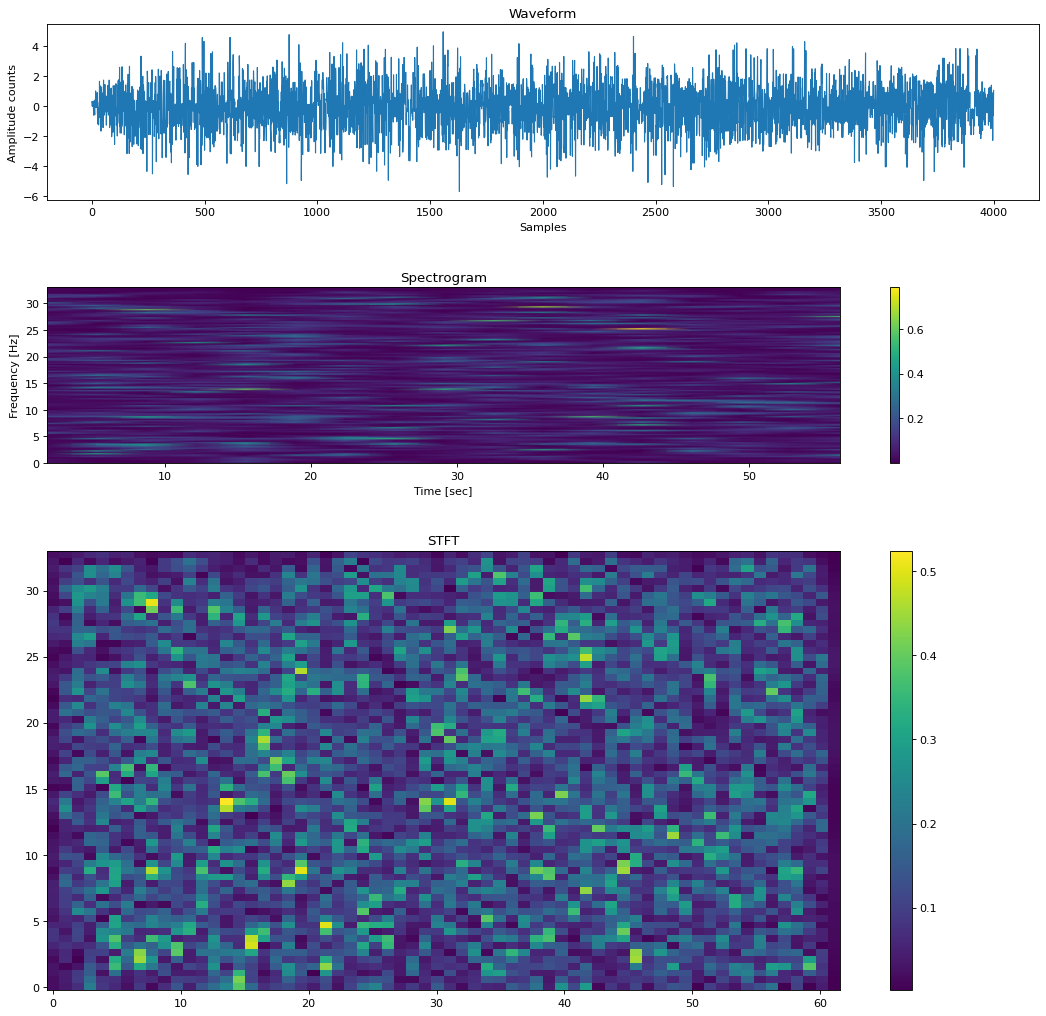

In [37]:
test_gen = make_generator_model(100)
test_fake = generate_fake_samples(test_gen, 100, 1)
test_reshaped = test_fake[0].reshape(test_fake[0].shape[0], 64, 64)[0]
test_inversed = istft(test_reshaped, window="hanning", fs=66, nperseg=127)
plot_single_stream(test_inversed[1][:4000], "", 66, 127)

In [ ]:
# # size of the latent space
# latent_dim = 100
# # create the discriminator
# d_model = make_discriminator_model()
# # create the generator
# g_model = make_generator_model(latent_dim)
# # create the gan
# gan_model = define_gan(g_model, d_model)
# # load image data
# dataset = load_real_samples()
# # train model
# train(g_model, d_model, gan_model, dataset, latent_dim)